### Importing the libraries

In [1]:
import os
import numpy as np
import cv2 # used only for loading the image
import matplotlib.pyplot as plt # used only for displaying the image
from tqdm import tqdm

### Setting up the images and required functions

In [2]:
# Loading the images in grayscale and then storing them in a list for subsequent processing.
img_size = 256 # setting the size of the image
imagefolder_path = os.path.join(os.getcwd(), 'Dataset', 'NLM') # path to the folder containing the images
image_set = []
# create list of only jpg and png images
image_list = [f for f in os.listdir(imagefolder_path) if f.endswith('.jpg') or f.endswith('.png')]
image_list.sort()
for image_name in image_list: # iterate over all the images in the folder
    img = cv2.imread(os.path.join(imagefolder_path, image_name), cv2.IMREAD_GRAYSCALE) # read the image in grayscale
    img = cv2.resize(img, (img_size, img_size))
    image_set.append(img) # append the image to the list

In [3]:
# this function is used to add gaussian noise to the image
def add_gaussian_noise(image, sigma): 
    noisy_image = image.copy() # copy the image
    row, col = noisy_image.shape # get the shape of the image
    gauss = np.random.normal(0, sigma, (row, col)) # generate the gaussian noise
    noisy_image = noisy_image + gauss # add the noise to the image
    return noisy_image  # return the noisy image

# this function is used to get the PSNR value of the image compared to the original image
def getPSNR(original_image, noisy_image):
    mse = np.mean((original_image - noisy_image)**2) # calculate the mean square error
    if mse == 0: # if mse is 0, then return 100
        return 100
    return 20 * np.log10(255.0 / np.sqrt(mse)) # return the PSNR value

# this function is used to get the MSE value of the image compared to the original image
def getMSE(original_image, noisy_image):
    mse = np.mean((original_image - noisy_image)**2) # calculate the mean square error
    return mse

# this function is used to get MSE and PSNR values of the image compared to the original image
def getStats(original, noisy, denoised, display=False):

    if display: 
        figure, axes = plt.subplots(1, 4, figsize=(15, 5))
        axes[0].imshow(original, cmap='gray') # display the original image
        axes[0].axis('off')
        axes[0].set_title('Original Image', fontsize=10)
        axes[1].imshow(noisy, cmap='gray') # display the noisy image
        axes[1].axis('off')
        axes[1].set_title('Noisy Image', fontsize=10)
        axes[2].imshow(denoised, cmap='gray') # display the denoised image
        axes[2].axis('off')
        axes[2].set_title('Denoised Image', fontsize=10)
        axes[3].imshow(np.abs(original-denoised), cmap='gray') # display the difference image
        axes[3].axis('off')
        axes[3].set_title('Difference Image', fontsize=10)
        plt.show()

    mse_noisy = getMSE(original, noisy) # get the MSE value of the noisy image
    mse_denoised = getMSE(original, denoised) # get the MSE value of the denoised image
    psnr_noisy = getPSNR(original, noisy) # get the PSNR value of the noisy image
    psnr_denoised = getPSNR(original, denoised) # get the PSNR value of the denoised image

    if display:
        print(f'MSE of Noisy Image: {mse_noisy:.2f}')
        print(f'MSE of Denoised Image: {mse_denoised:.2f}\n')
        print(f'PSNR of Noisy Image: {psnr_noisy:.2f}')
        print(f'PSNR of Denoised Image: {psnr_denoised:.2f}\n')

    return mse_noisy, mse_denoised, psnr_noisy, psnr_denoised
 

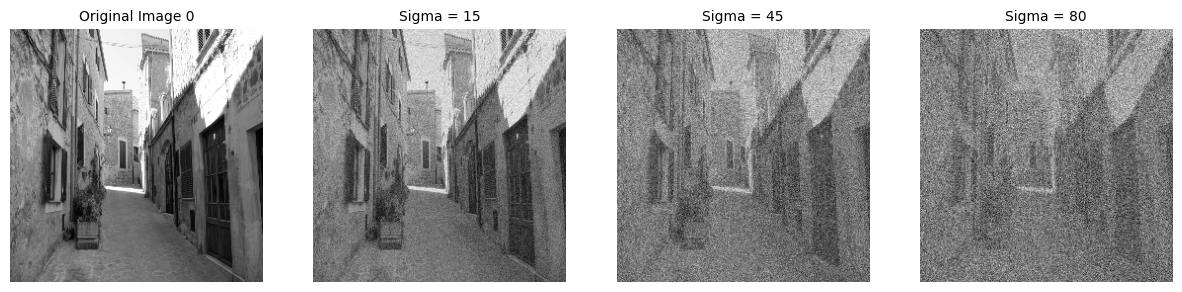

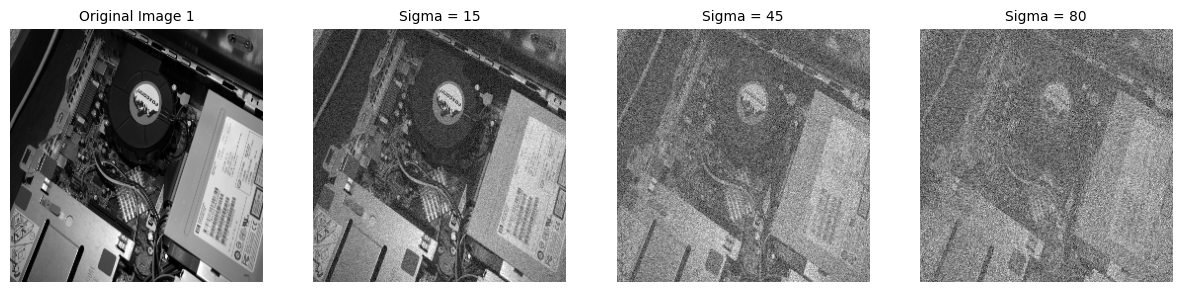

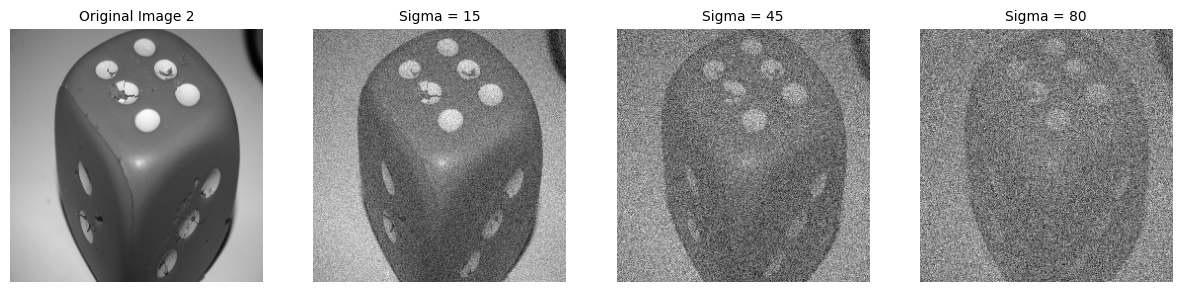

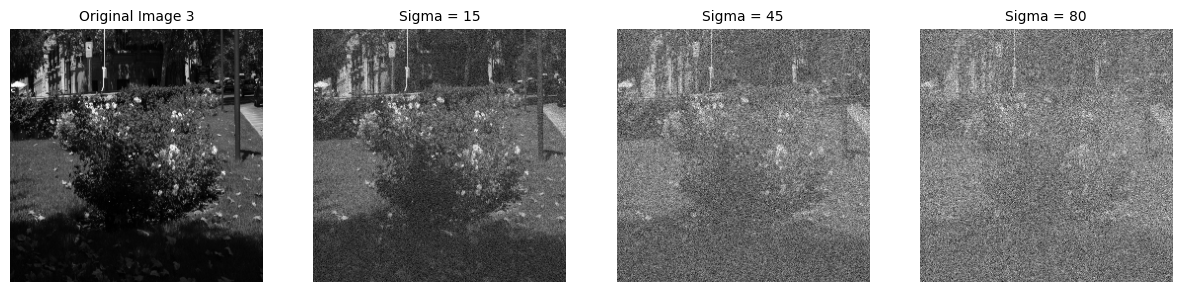

In [4]:
SIGMA = [15, 45, 80] # list of sigma values

noisy15 = [] # list to store the noisy images with sigma = 15
noisy45 = [] # list to store the noisy images with sigma = 45
noisy80 = [] # list to store the noisy images with sigma = 80

# iterate over all the images in the image set and add the gaussian noise to them
for idx in range(len(image_set)): 
    fig, axes = plt.subplots(1, len(SIGMA)+1, figsize=(15, 5))
    axes[0].imshow(image_set[idx], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image '+str(idx), fontsize=10)

    for i, s in enumerate(SIGMA):
        noisy_image = add_gaussian_noise(image_set[idx], s)
        axes[i+1].imshow(noisy_image, cmap='gray')
        axes[i+1].set_title(f'Sigma = {s}', fontsize=10)
        axes[i+1].axis('off')
        # store the noisy image in the corresponding list
        if s == 15: 
            noisy15.append(noisy_image)
        elif s == 45:
            noisy45.append(noisy_image)
        else:
            noisy80.append(noisy_image)
    plt.show() # display the images

# create a dictionary to store the noisy images
image_pool = {
    0: image_set,
    15: noisy15,
    45: noisy45,
    80: noisy80
}

### Defining the NLM functionalities

In [5]:
# funtion to add padding to the image
def getPaddedImage(image, padwidth):
    paddedImage = np.zeros((image.shape[0] + 2 * padwidth, image.shape[1] + 2 * padwidth), dtype=np.uint8) 
    paddedImage[padwidth:padwidth+image.shape[0], padwidth:padwidth+image.shape[1]] = image
    return paddedImage

# function to get the comparison value
def getComparison(image, X, Y, r, f, B, h, sigma):
    Iw, w = 0, 0
    for i in range(X, X + r - f, 1):  # iterate over the window
        for j in range(Y, Y + r - f, 1):   
            B0 = image[j:j+f, i:i+f] # get the comparison patch
            euclideanDistance = np.sum(np.square(B0 - B)) # calculate the euclidean distance
            numerator = max(euclideanDistance - 2*sigma*sigma, 0) 
            w0 = np.exp(-1*(numerator/(h*h))) # calculate the weight
            w += w0 # add the weight to the sum
            f0 = int((f-1)/2)
            Iw += w0*image[j + f0, i + f0] 
            
    I_cap = Iw/w # calculate the comparison value
    return I_cap # return the comparison value

# function to apply the non local means
def NLM(image, r, f, h, sigma):
    padwidth = int((r-1)/2) # calculate the padding width
    image_padded = getPaddedImage(image, padwidth) # get the padded image
    
    num_iters = image.shape[1]*image.shape[0] # calculate the number of iterations
    result = np.zeros(image_padded.shape, dtype=np.uint8) # create a denoised image

    with tqdm(total=num_iters) as pbar: # create a progress bar
        # iterate over the image
        for x in range(padwidth, padwidth + image.shape[1]): 
            for y in range(padwidth, padwidth + image.shape[0]):
                X = x - padwidth  # get the x coordinate of the comparison window
                Y = y - padwidth  # get the y coordinate of the comparison window
                f0 = int((f-1)/2) 
                B = image_padded[y-f0 : y+f0+1, x-f0 : x+f0+1] # get the center patch
                I_cap = getComparison(image_padded, X, Y, r, f, B, h, sigma) # get the comparison value between the center patch and other patches in the research window
                result[y, x] = np.floor(I_cap)  # update the denoised image
                pbar.update(1) # update the progress bar

    return result[padwidth:padwidth+image.shape[0],padwidth:padwidth+image.shape[1]] # return the denoised image

In [ ]:
f_list = [3, 5, 7, 9] # list of comparison window sizes
r_list = [21, 35] # list of research window sizes
k_list = [0.05, 0.2, 0.35, 0.6]  # list of k values


with open('results.csv', 'a') as file:
    file.write('image,sigma,f,r,k,h,mse_noisy,mse_denoised,psnr_noisy,psnr_denoised\n')

for sigma in list(image_pool.keys()):
    if sigma == 0:
        continue

    for img_index in range(len(image_pool[sigma])):
        noisy_image = image_pool[sigma][img_index]
        original_image = image_pool[0][img_index]
        
        if sigma == 80: r = r_list[1]
        else: r = r_list[0]

        for f in f_list:
            for k in k_list:

                h = k*sigma
                print(f'Image: {img_index}, sigma: {sigma}, f: {f}, r: {r}, k: {k}, h: {h}')

                result = NLM(image=np.uint8(noisy_image), r=r, f=f, h=h, sigma=sigma)
                stats = getStats(original_image, noisy_image, result, display=False)

                # save the results in a csv file
                with open('results.csv', 'a') as file:
                    file.write(f'{img_index},{sigma},{f},{r},{k},{h},{stats[0]},{stats[1]},{stats[2]},{stats[3]}\n')

### Analysis of the results obtained

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

In [7]:
# open the csv file
df = pd.read_csv('results.csv')

In [8]:
rcParams['axes.titlepad'] = 20 # padding for the plot title

# this funtion returns the anysis for the given image and sigma
def getAnanysis(image, sigma):
    df0 = df[df['image'] == image]
    df0_s = df0[df0['sigma'] == sigma]
    df_max = df0_s[df0_s['psnr_denoised'] == df0_s['psnr_denoised'].max()]
    df_max = df_max.rename(columns={'image': 'Image', 'sigma': 'Sigma', 'h': 'Optimum h', 'mse_noisy': 'MSE Noisy', 
                                      'f' : 'F', 'r' : 'R', 'k': 'K',
                                      'mse_denoised': 'MSE Denoised', 'psnr_noisy': 'PSNR Noisy', 'psnr_denoised': 'PSNR Denoised'})
    return df_max[0:1]

# this function returns the best analysis for the given image
def getBest(image):
    df_result = pd.DataFrame()
    df_result = pd.concat([df_result, getAnanysis(image, 15)], ignore_index=True)
    df_result = pd.concat([df_result, getAnanysis(image, 45)], ignore_index=True)
    df_result = pd.concat([df_result, getAnanysis(image, 80)], ignore_index=True)
    return df_result

# this function plots the analysis for the given image, sigma and f values
def plotAnalysis(image, sigma, f_list):
    fig, axes = plt.subplots(1, len(f_list), figsize=(15, 3))
    for i, f in enumerate(f_list):
        df0 = df[df['image'] == image]
        df1 = df0[df0['f'] == f]
        df2 = df1[df1['sigma'] == sigma]
        
        axes[i].plot(df2['h'], df2['psnr_denoised'], label='sigma = ' + str(sigma), alpha=0.7)
        df_max = df2[df2['psnr_denoised'] == df2['psnr_denoised'].max()]
        axes[i].scatter(df_max['h'], df_max['psnr_denoised'], marker='o',label='Optimum h', color='black', s=20)
        
        axes[i].set_xlabel('h')
        axes[i].set_ylabel('PSNR')
        axes[i].set_title('Image = ' + str(image) + ', sigma = ' + str(sigma) + ', f = ' + str(f), fontsize=10)
        axes[i].legend()
        axes[i].grid()
    
    plt.tight_layout()  
    plt.show()

# this function plots the compiled analysis for the given image
def getAnalysis(image):
    print('Plotting for Image ' + str(image), '\n')
    sigmas = [15, 45, 80]
    fs = [3, 5, 7, 9]
    for s in sigmas:
        plotAnalysis(image, s, fs) 
    plt.show()

#### Image 0

Plotting for Image 0 



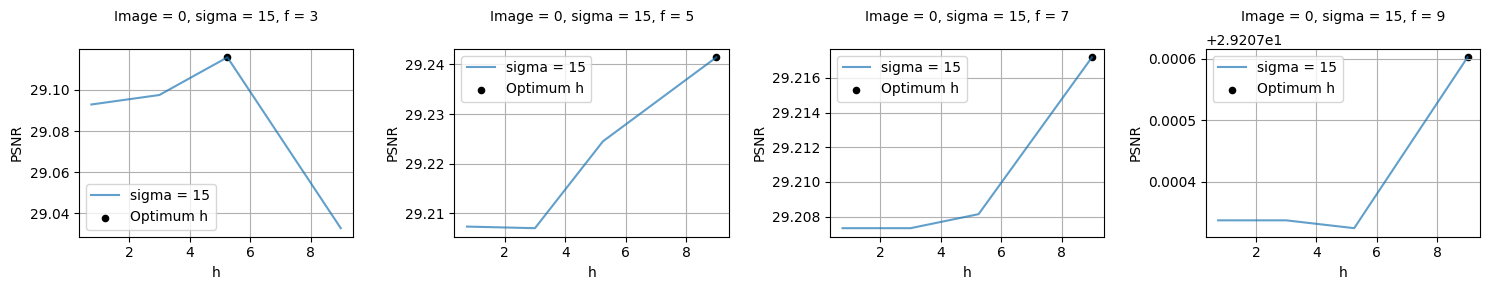

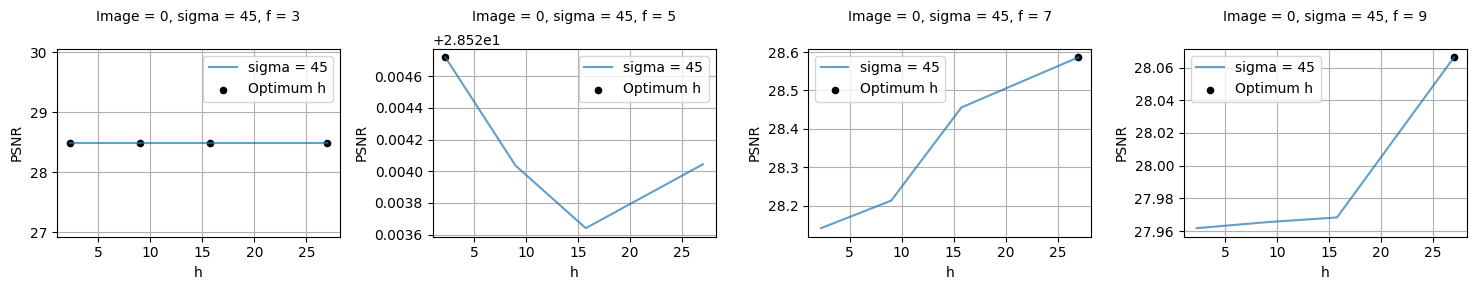

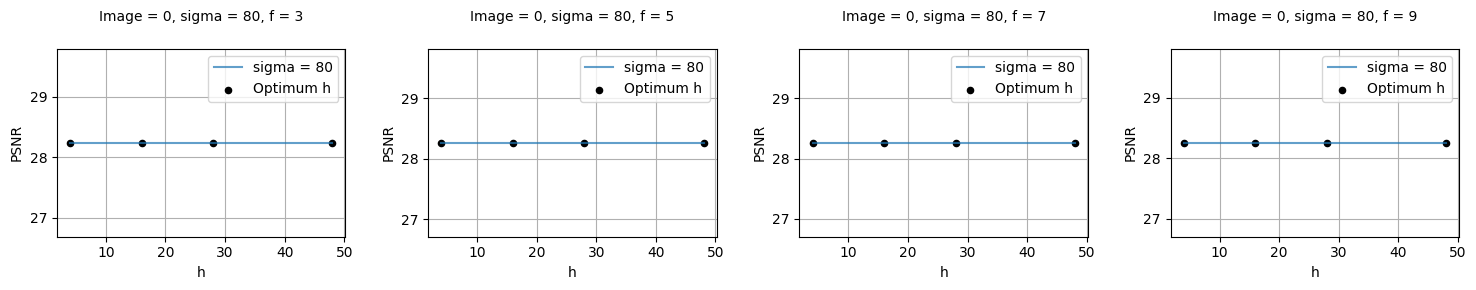


Optimum stats of Image 0 for different Sigma values



Image  Sigma  F   R     K  Optimum h    MSE Noisy  MSE Denoised  \
0      0     15  5  21  0.60        9.0   225.750569     77.435028   
1      0     45  7  21  0.60       27.0  2033.781032     90.043854   
2      0     80  5  35  0.05        4.0  6362.757848     96.997910   

   PSNR Noisy  PSNR Denoised  
0   24.594515      29.241429  
1   15.047762      28.586263  
2   10.094350      28.263180

In [9]:
getAnalysis(0)
print('\nOptimum stats of Image 0 for different Sigma values\n')
getBest(image = 0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [02:55<00:00, 374.15it/s]


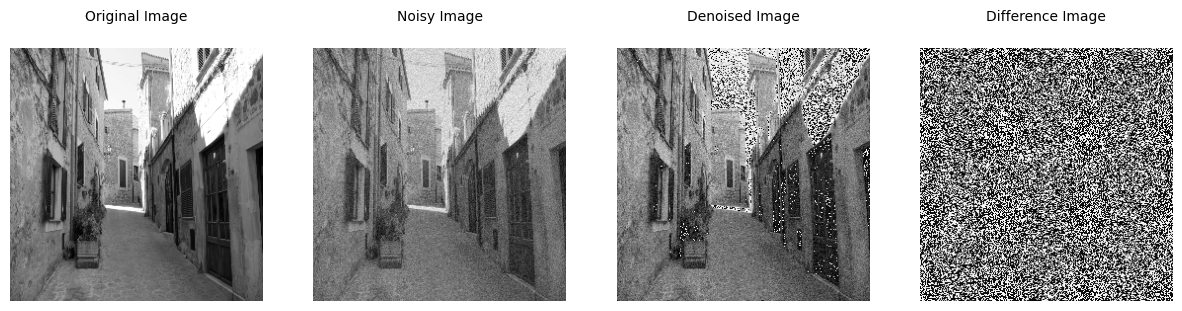

MSE of Noisy Image: 224.86
MSE of Denoised Image: 77.76

PSNR of Noisy Image: 24.61
PSNR of Denoised Image: 29.22



In [10]:
# Denoising with the optimum values
image, sigma, f, r, h = 0, 15, 5, 21, 9 
result = NLM(image=np.uint8(image_pool[sigma][image]), r=r, f=f, h=h, sigma=sigma)
stats = getStats(image_pool[0][image], image_pool[sigma][image], result, display=True)

#### Image 1

Plotting for Image 1 



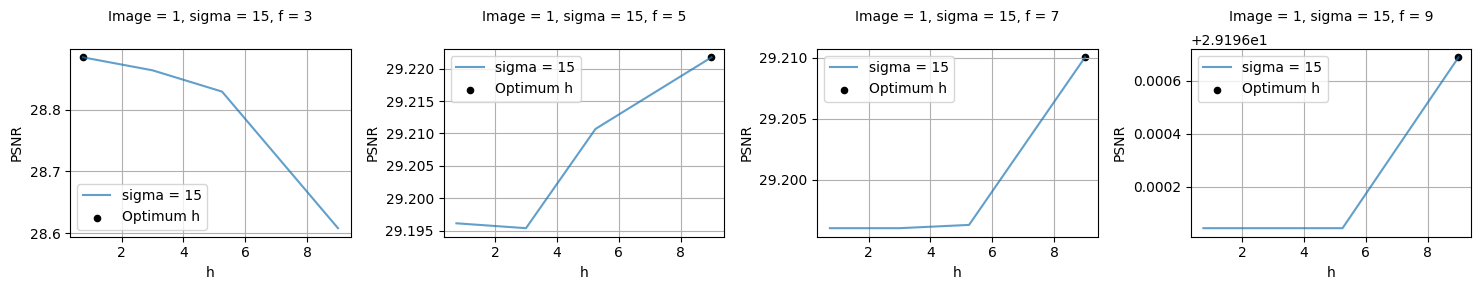

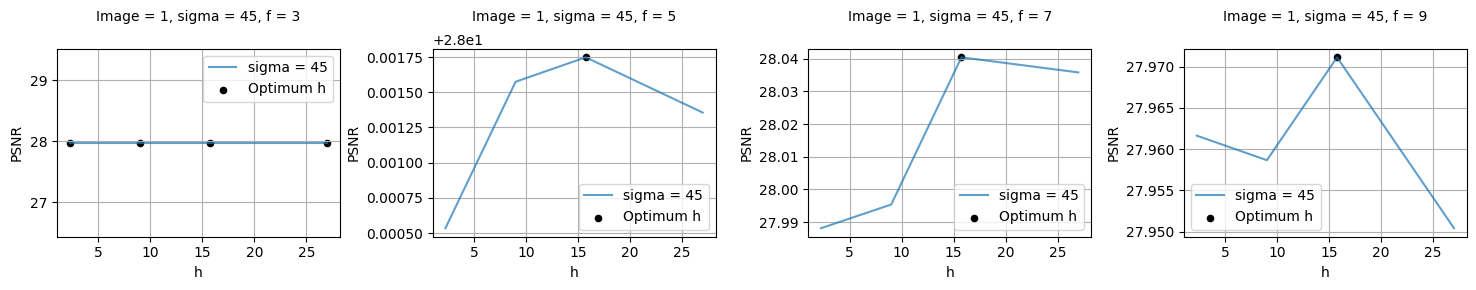

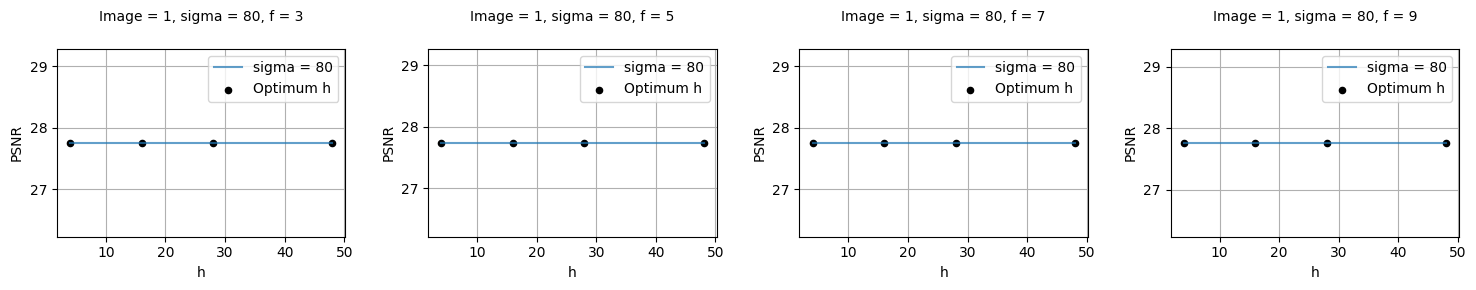


Optimum stats of Image 1 for different Sigma values



Image  Sigma  F   R     K  Optimum h    MSE Noisy  MSE Denoised  \
0      1     15  5  21  0.60       9.00   225.393005     77.787003   
1      1     45  7  21  0.35      15.75  2037.057186    102.102417   
2      1     80  9  35  0.05       4.00  6422.667925    108.807724   

   PSNR Noisy  PSNR Denoised  
0   24.601399      29.221733  
1   15.040771      28.040443  
2   10.053649      27.764206

In [39]:
getAnalysis(1)
print('\nOptimum stats of Image 1 for different Sigma values\n')
getBest(image = 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [02:57<00:00, 369.16it/s]


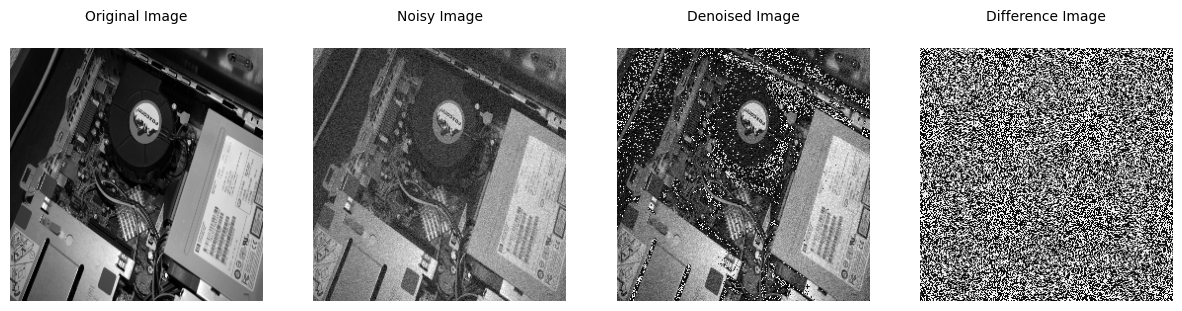

MSE of Noisy Image: 223.92
MSE of Denoised Image: 77.42

PSNR of Noisy Image: 24.63
PSNR of Denoised Image: 29.24



In [12]:
# Denoising with the optimum values
image, sigma, f, r, h = 1, 15, 5, 21, 9 
result = NLM(image=np.uint8(image_pool[sigma][image]), r=r, f=f, h=h, sigma=sigma)
stats = getStats(image_pool[0][image], image_pool[sigma][image], result, display=True)

#### Image 2

Plotting for Image 2 



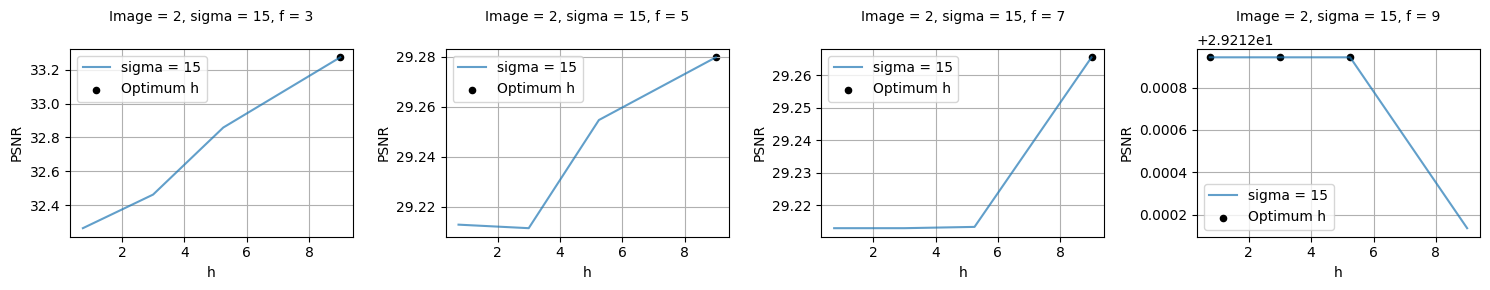

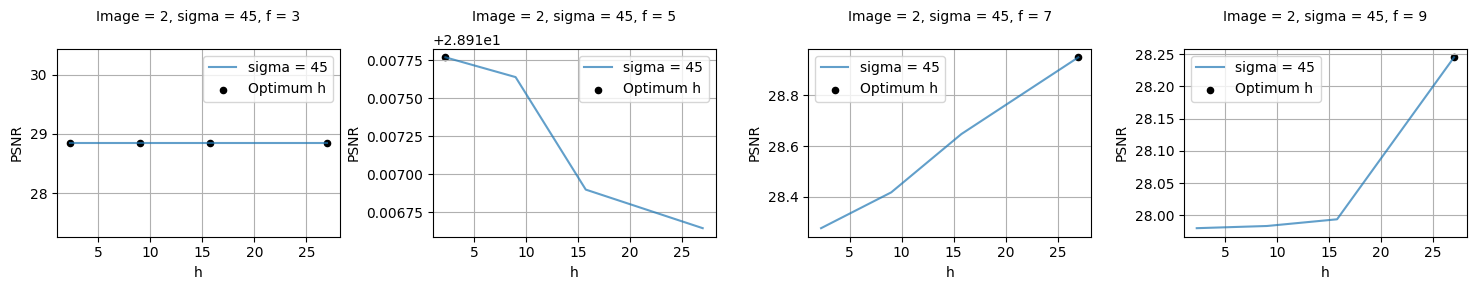

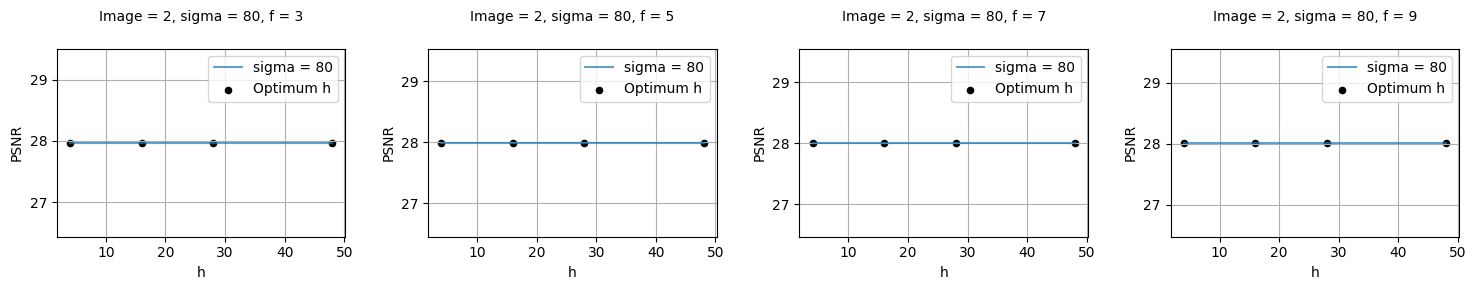


Optimum stats of Image 2 for different Sigma values



Image  Sigma  F   R     K  Optimum h    MSE Noisy  MSE Denoised  \
0      2     15  3  21  0.60        9.0   224.381217     30.602051   
1      2     45  7  21  0.60       27.0  2026.872861     82.821640   
2      2     80  9  35  0.05        4.0  6411.461156    102.665375   

   PSNR Noisy  PSNR Denoised  
0   24.620939      33.273298  
1   15.062539      28.949365  
2   10.061233      28.016564

In [40]:
getAnalysis(2)
print('\nOptimum stats of Image 2 for different Sigma values\n')
getBest(image = 2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [04:15<00:00, 256.58it/s]


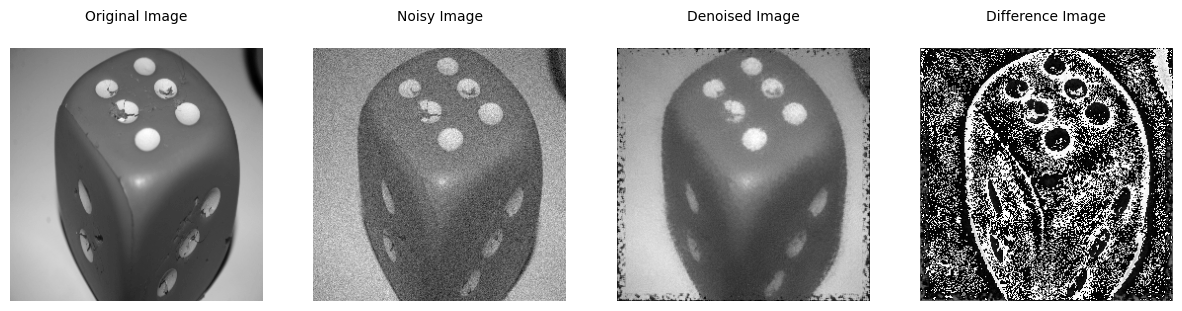

MSE of Noisy Image: 225.78
MSE of Denoised Image: 30.63

PSNR of Noisy Image: 24.59
PSNR of Denoised Image: 33.27



In [13]:
# Denoising with the optimum values
image, sigma, f, r, h = 2, 15, 3, 21, 9 
result = NLM(image=np.uint8(image_pool[sigma][image]), r=r, f=f, h=h, sigma=sigma)
stats = getStats(image_pool[0][image], image_pool[sigma][image], result, display=True)

#### Image 3

Plotting for Image 3 



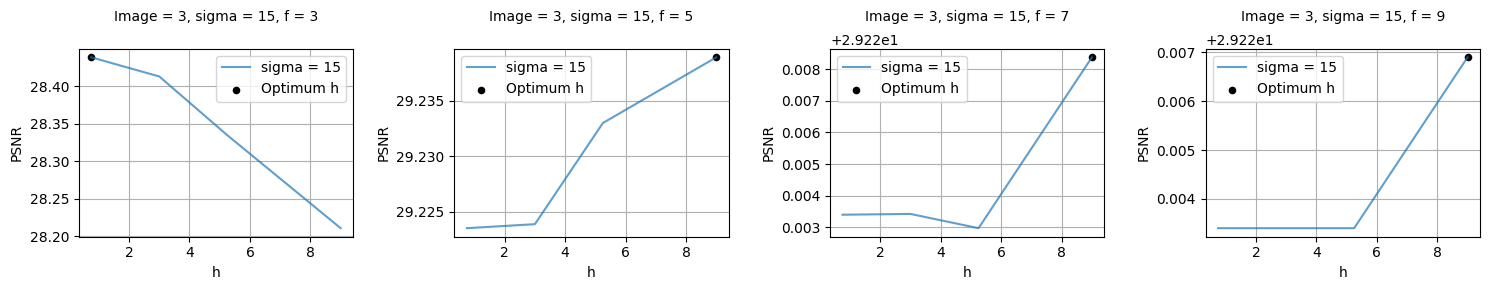

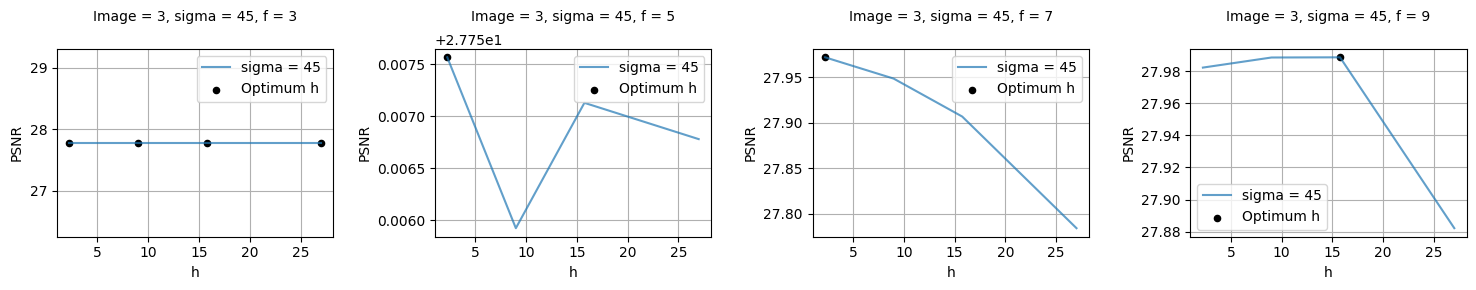

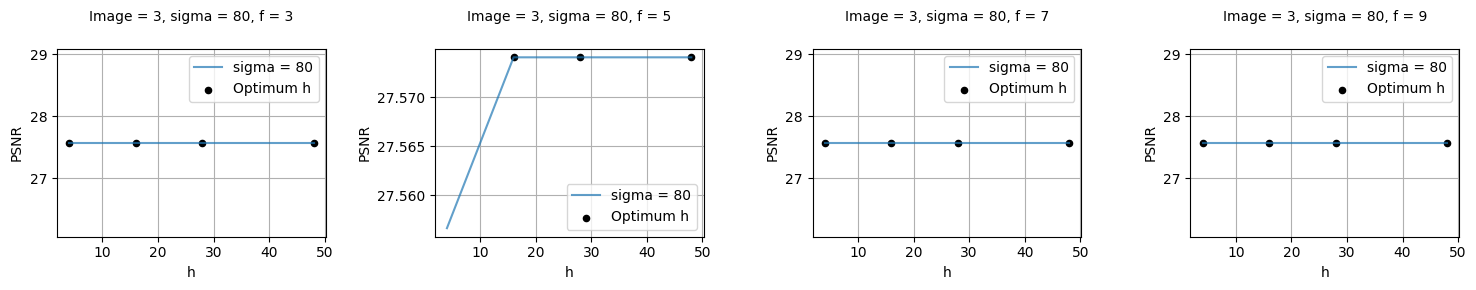


Optimum stats of Image 3 for different Sigma values



Image  Sigma  F   R     K  Optimum h    MSE Noisy  MSE Denoised  \
0      3     15  5  21  0.60       9.00   223.490709     77.480606   
1      3     45  9  21  0.35      15.75  2043.726862    103.326492   
2      3     80  3  35  0.05       4.00  6381.607095    113.652237   

   PSNR Noisy  PSNR Denoised  
0   24.638209      29.238874  
1   15.026575      27.988687  
2   10.081503      27.575024

In [41]:
getAnalysis(3)
print('\nOptimum stats of Image 3 for different Sigma values\n')
getBest(image = 3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [03:07<00:00, 350.23it/s]


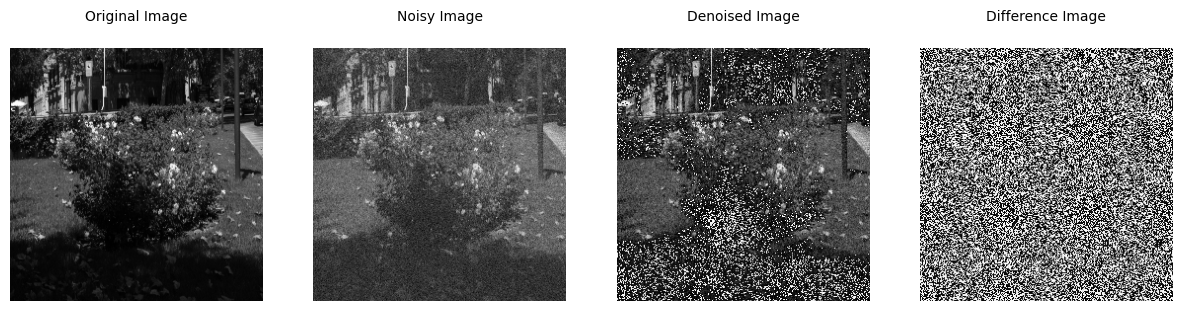

MSE of Noisy Image: 221.88
MSE of Denoised Image: 77.22

PSNR of Noisy Image: 24.67
PSNR of Denoised Image: 29.25



In [14]:
# Denoising with the optimum values
image, sigma, f, r, h = 3, 15, 5, 21, 9 
result = NLM(image=np.uint8(image_pool[sigma][image]), r=r, f=f, h=h, sigma=sigma)
stats = getStats(image_pool[0][image], image_pool[sigma][image], result, display=True)

### References

- <a href="https://github.com/scikit-image/scikit-image/blob/main/skimage/restoration/non_local_means.py">Sklern Implementation</a>
- <a href="https://doi.org/10.5201/ipol.2011.bcm_nlm">Non-Local Means Denoising</a>
- <a href="https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio">PSNR</a>
- <a href="https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/">Python Implementation of PSNR</a>
- <a href="https://quasar.ugent.be/bgoossen/download_nlmeans/">An Improved Non-Local Means Algorithm for Image Denoising</a>